# 04. Noisy Networks for Exploration

[M. Fortunato et al., "Noisy Networks for Exploration." arXiv preprint arXiv:1706.10295, 2017.](https://arxiv.org/pdf/1706.10295.pdf)


NoisyNet is an exploration method that learns perturbations of the network weights to drive exploration. The key insight is that a single change to the weight vector can induce a consistent, and potentially very complex, state-dependent change in policy over multiple time steps.

Firstly, let's take a look into a linear layer of a neural network with $p$ inputs and $q$ outputs, represented by

$$
y = wx + b,
$$

where $x \in \mathbb{R}^p$ is the layer input, $w \in \mathbb{R}^{q \times p}$, and $b \in \mathbb{R}$ the bias.

The corresponding noisy linear layer is defined as:

$$
y = (\mu^w + \sigma^w \odot \epsilon^w) x + \mu^b + \sigma^b \odot \epsilon^b,
$$

where $\mu^w + \sigma^w \odot \epsilon^w$ and $\mu^b + \sigma^b \odot \epsilon^b$ replace $w$ and $b$ in the first linear layer equation. The parameters $\mu^w \in \mathbb{R}^{q \times p}, \mu^b \in \mathbb{R}^q, \sigma^w \in \mathbb{R}^{q \times p}$ and $\sigma^b \in \mathbb{R}^q$ are learnable, whereas $\epsilon^w \in \mathbb{R}^{q \times p}$ and $\epsilon^b \in \mathbb{R}^q$ are noise random variables which can be generated by one of the following two ways:

1. **Independent Gaussian noise**: the noise applied to each weight and bias is independent, where each random noise entry is drawn from a unit Gaussian distribution. This means that for each noisy linear layer, there are $pq + q$ noise variables (for $p$ inputs to the layer and $q$ outputs).
2. **Factorised Gaussian noise:** This is a more computationally efficient way. It produces 2 random Gaussian noise vectors ($p, q$) and makes $pq + q$ noise entries by outer product as follows:

$$
\begin{align}
\epsilon_{i,j}^w &= f(\epsilon_i) f(\epsilon_j),\\
\epsilon_{j}^b &= f(\epsilon_i),\\
\text{where } f(x) &= sgn(x) \sqrt{|x|}.
\end{align}
$$

In all experiements of the paper, the authors used Factorised Gaussian noise, so we will go for it as well.

In [1]:
import math
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

## Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size, self.batch_size = 0, 0, size, batch_size

    def store(self, obs: np.ndarray, act: np.ndarray, rew: float, next_obs: np.ndarray, done: bool):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Noisy Layer

In [3]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    References:
        https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb
        https://github.com/Kaixhin/Rainbow/blob/master/model.py
        
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.Tensor(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.FloatTensor(np.random.normal(loc=0.0, scale=1.0, size=size))

        return x.sign().mul(x.abs().sqrt())

## Noisy Network

We use NoisyLinear for the last two FC layers. This is the only difference from the example of *01.dqn.ipynb*.

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.feature = nn.Linear(in_dim, 128)
        self.noisy_layer1 = NoisyLinear(128, 128)
        self.noisy_layer2 = NoisyLinear(128, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        feature = F.relu(self.feature(x))
        hidden = F.relu(self.noisy_layer1(feature))
        out = self.noisy_layer2(hidden)
        
        return out
    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.noisy_layer1.reset_noise()
        self.noisy_layer2.reset_noise()

## DQN + NoisyNet Agent (w/o DuelingNet)

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

In the paper, NoisyNet is used as a component of the Dueling Network Architecture, which includes Double-DQN and Prioritized Experience Replay. However, we don't implement them to simplify the tutorial. One thing to note is that NoisyNet is an alternertive to $\epsilon$-greedy method, so all $\epsilon$ related lines are removed. Please check all comments with *NoisyNet*.

In [5]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        gamma: float = 0.99,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            gamma (float): discount factor
        """
        # NoisyNet: All attributes related to epsilon are removed
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(
            torch.FloatTensor(state).to(self.device)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        # https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_
        clip_grad_norm_(self.dqn.parameters(), 1.0, norm_type=1)
        self.optimizer.step()
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            
            # NoisyNet: removed decrease of epsilon

            # if episode ends
            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)
                
        self.env.close()
                
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        while not done:
            self.env.render()
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        state = torch.FloatTensor(samples["obs"]).to(self.device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(self.device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(self.device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(self.device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(self.device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = ((target - curr_q_value).pow(2)).mean()

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.show()

## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [6]:
# environment
env_id = "CartPole-v0"
env = gym.make(env_id)

## Set random seed

The following is how to set the random seed for reproducibility, which is guided from [pytorch documents](https://pytorch.org/docs/stable/notes/randomness.html). Unfortunately, it doesn't work properly for now (pytorch 1.0.1).

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

## Training

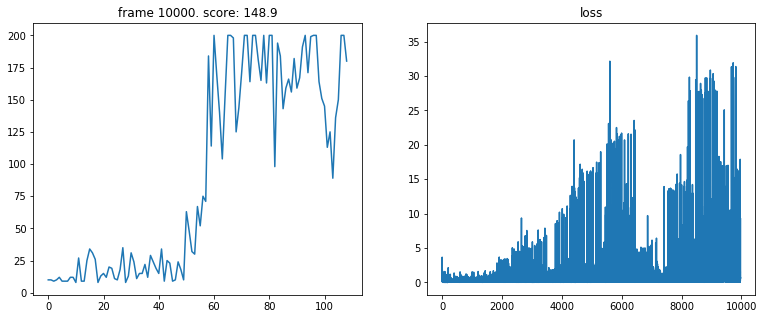

In [8]:
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
target_update = 200

# train
agent = DQNAgent(env, memory_size, batch_size, target_update)
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [9]:
agent.test()

score:  200.0
